In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
#, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adamax, Nadam
from tensorflow.keras.layers import TimeDistributed, Conv1D, RepeatVector, Conv2D, Conv3D

In [4]:
#Reading the file saved from  ETL file
df = pd.read_csv('dataset.csv')

In [5]:
#Analizing SKU_01
sku="SKU_01"
df_sku = df[['SKU', 'Volume', 'Avg_Max_Temp', 'Promotions']]
df_sku = df_sku.groupby(['SKU']).sum()
df_sku_sel = df[df['SKU'] == sku][['YearMonth','Volume', 'Avg_Population_2017', 'Avg_Max_Temp', 'Promotions']]
df_sku_sel = df_sku_sel.groupby(['YearMonth']).agg({ 'Volume': np.mean, 'Avg_Max_Temp' : np.mean, 'Promotions':np.mean  })


In [6]:
# funtion to serialize the data for time series. I took it from this web page
# https://www.tensorflow.org/tutorials/structured_data/time_series
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [7]:
# funtion to plot train and validation lost. 
# I took it from this web page
# https://www.tensorflow.org/tutorials/structured_data/time_series
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()

In [8]:
# The data is 60 month of data. We will split is 51 month for Training, 3 for validation and 3 for test.
# We loose 3 when we convert to Univariate data  
values = df_sku_sel.values
values = values.astype('float32')
train = 50
val = 3

In [9]:
#First Way scaling all at the same time one.
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import scale, MaxAbsScaler, QuantileTransformer,  PowerTransformer 
scaller1 = MaxAbsScaler()

std1 = values[:train,:].reshape(values[:train,:].shape[0],values[:train,:].shape[1])
scaled1_train = scaller1.fit_transform(std1)
std1 = values[train:,:].reshape(values[train:,:].shape[0],values[train:,:].shape[1])
scaled1_test = scaller1.transform(std1)
scaled1 = np.concatenate((scaled1_train,scaled1_test), axis = 0 )

In [11]:
# Using time step 3 with 1 output
history_size = 3
target_size = 0

# Preparing Dimension of Volume
X, y = univariate_data(scaled1[:,0], 0, len(scaled1), history_size, target_size)
y = scaled1[3:,0]
X1, y1 = univariate_data(scaled1[:,1], 0, len(scaled1), history_size, target_size)
X2, y2 = univariate_data(scaled1[:,2], 0, len(scaled1), history_size, target_size)
X = np.concatenate((X,X1,X2), axis = 2 )

In [12]:
# The data is 60 month of data. We will split is 51 month for Training, 6 for validation and 6 for test.
#X, y = values[:,:-1], values[:,-1:]
x_train_uni, y_train_uni = X[: train] , y[:train]
x_val_uni, y_val_uni = X[train: train + val ] , y[train: train + val]
x_test_uni, y_test_uni = X[train + val:] , y[train + val:]

In [13]:
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', dropout=0.4,  return_sequences=True ))
model.add(LSTM(100, activation='relu',  return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 300)            364800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 200)            400800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 100)            120400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 916,251
Trainable params: 916,251
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.3171355602786764
mse=  0.0060349368
rmse=  0.07768486


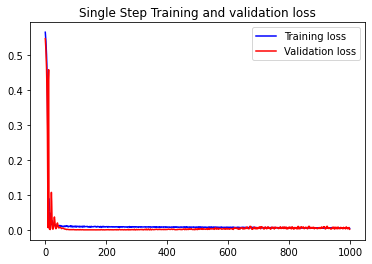

In [14]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

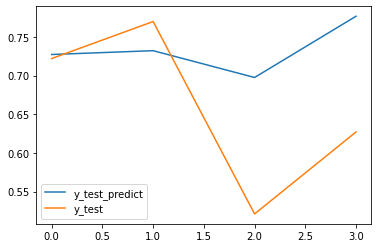

r2_Score=  -0.5145029059525972
mse=  0.013709915
rmse=  0.117089346


In [15]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [16]:
#Analizing SKU_02
sku="SKU_02"
df_sku = df[['SKU', 'Volume', 'Avg_Max_Temp', 'Promotions']]
df_sku = df_sku.groupby(['SKU']).sum()
df_sku_sel = df[df['SKU'] == sku][['YearMonth','Volume', 'Avg_Population_2017', 'Avg_Max_Temp', 'Promotions']]
df_sku_sel = df_sku_sel.groupby(['YearMonth']).agg({ 'Volume': np.mean, 'Avg_Max_Temp' : np.mean, 'Promotions':np.mean  })

In [17]:
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', dropout=0.4,  return_sequences=True ))
model.add(LSTM(100, activation='relu',  return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 300)            364800    
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 200)            400800    
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 100)            120400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 916,251
Trainable params: 916,251
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.2898325458220816
mse=  0.0062762327
rmse=  0.07922268


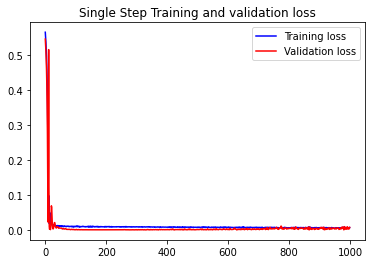

In [18]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

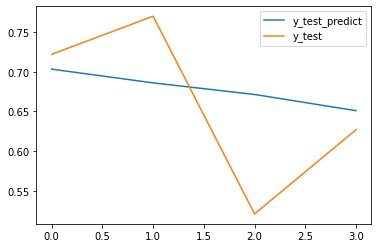

r2_Score=  0.15832132850557912
mse=  0.007619228
rmse=  0.08728819


In [19]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [20]:
#Analizing SKU_03
sku="SKU_03"
df_sku = df[['SKU', 'Volume', 'Avg_Max_Temp', 'Promotions']]
df_sku = df_sku.groupby(['SKU']).sum()
df_sku_sel = df[df['SKU'] == sku][['YearMonth','Volume', 'Avg_Population_2017', 'Avg_Max_Temp', 'Promotions']]
df_sku_sel = df_sku_sel.groupby(['YearMonth']).agg({ 'Volume': np.mean, 'Avg_Max_Temp' : np.mean, 'Promotions':np.mean  })

In [21]:
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', dropout=0.4,  return_sequences=True ))
model.add(LSTM(100, activation='relu',  return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 3, 300)            364800    
_________________________________________________________________
lstm_9 (LSTM)                (None, 3, 200)            400800    
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 100)            120400    
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 916,251
Trainable params: 916,251
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.3937788699109448
mse=  0.0053575877
rmse=  0.07319555


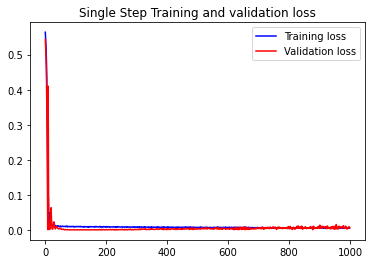

In [22]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

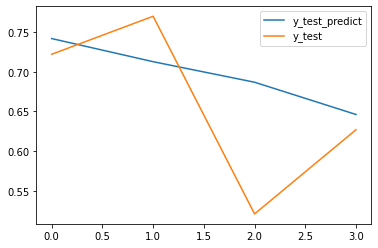

r2_Score=  0.132082787825211
mse=  0.007856751
rmse=  0.08863831


In [23]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [19]:
# It is clear that the model need o be tunned using additional hyperparameters or different architecture.
# My goal on this training cover my expectations. 
# Try to  tune this model make not sence for me.  But the knowledge acquired was amazing.  